In [401]:
# ========== IMPORTS ==========
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from shapely.geometry import Polygon, Point
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut


# ========== CONFIG ==========
FEATURES = ['entropy', 'pupil_mean', 'pupil_std', 'pupil_valid_ratio']
TARGET = 'distraction_level'
CLUSTER_K = 3
# ============================

def load_participant_figure_data(base_dir, participant_id=None, figure_name=None) -> dict:
    participants = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    if participant_id is None:
        if not participants:
            raise RuntimeError("No participant folders found.")
        participant_id = participants[0]

    print(f"[INFO] Testing participant: {participant_id}")
    participant_path = os.path.join(base_dir, participant_id)
    figure_names = [d for d in os.listdir(participant_path) if os.path.isdir(os.path.join(participant_path, d))]

    if not figure_names:
        raise RuntimeError(f"No figure folders found for {participant_id}")
    
    figure_name = figure_names[0]
    print(f"[INFO] Testing figure: {figure_name}")

    # paths
    fig_path = os.path.join(participant_path, figure_name)
    screen_path = os.path.join(fig_path, 'screen')
    table_path = os.path.join(fig_path, 'table')

    # gaze data
    df_screen = pd.read_csv(os.path.join(screen_path, 'gazepoints.csv'))
    df_table = pd.read_csv(os.path.join(table_path, 'gazepoints.csv'))
    print(f"[SUCCESS] Loaded screen gaze: {df_screen.shape}")
    print(f"[SUCCESS] Loaded table gaze: {df_table.shape}")

    # pupil data
    pupil_path = os.path.join(screen_path, 'pupil_info.csv')
    if not os.path.exists(pupil_path):
        raise FileNotFoundError(f"[ERROR] Missing pupil_info.csv for {participant_id} → {figure_name}")
    
    pupil_df = pd.read_csv(pupil_path)
    pupil_df = pupil_df.dropna(subset=['timestamp', 'diameter_right'])
    mean_d = pupil_df['diameter_right'].mean()
    std_d = pupil_df['diameter_right'].std()
    pupil_df['diameter_z'] = (pupil_df['diameter_right'] - mean_d) / std_d
    print(f"[INFO] Loaded pupil data: {pupil_df.shape}")

    # load screen events and states
    try:
        screen_events = pd.read_csv(os.path.join(screen_path, 'events.csv'))
        screen_states = pd.read_csv(os.path.join(screen_path, 'states.csv'))
        print("[INFO] Loaded screen events and states")
    except Exception as e:
        screen_events, screen_states = None, None
        print(f"[WARNING] Could not load screen events/states: {e}")

    # Load table events and states
    try:
        table_events = pd.read_csv(os.path.join(table_path, 'events.csv'))
        table_states = pd.read_csv(os.path.join(table_path, 'states.csv'))
        print("[INFO] Loaded table events and states")
    except Exception as e:
        table_events, table_states = None, None
        print(f"[WARNING] Could not load table events/states: {e}")

    return {
        'participant_id': participant_id,
        'figure_name': figure_name,
        'df_screen': df_screen,
        'df_table': df_table,
        'pupil_df': pupil_df,
        'screen_events': screen_events,
        'screen_states': screen_states,
        'table_events': table_events,
        'table_states': table_states
    }

data = load_participant_figure_data("gaipat_data/participants")
# df_screen = data['df_screen']
# df_table = data['df_table']
# pupil_df = data['pupil_df']

# # check if it works
# print(df_screen.head())
# print(df_table.head())
# print(pupil_df.head())


[INFO] Testing participant: 87891249
[INFO] Testing figure: sc
[SUCCESS] Loaded screen gaze: (4525, 3)
[SUCCESS] Loaded table gaze: (3432, 3)
[INFO] Loaded pupil data: (533, 6)
[INFO] Loaded screen events and states
[INFO] Loaded table events and states


In [402]:
def merge_preprocess_gaze(df_screen, df_table) -> pd.DataFrame:
    """
    Merges and preprocesses gaze data from screen and table into a single dataframe.
    - add source column
    - drop NaN
    - convert to seconds
    - sort by timestamp
    """

    # assign source labels
    df_screen['source'] = 'screen'
    df_table['source'] = 'table'

    # drop NaN, specifying columns in abundance of caution
    df_screen = df_screen.dropna(subset=['x', 'y', 'timestamp'])
    df_table = df_table.dropna(subset=['x', 'y', 'timestamp'])

    # merge dataframes
    df = pd.concat([df_screen, df_table], ignore_index=True)

    # sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    return df

df_merged = merge_preprocess_gaze(df_screen, df_table)

### Gaze Entropy

In [403]:
def calc_gaze_entropy(xy_points, bins=10) -> float:
    """
    Calculate spatial entropy of gaze data.
    Shannon entropy quantifies how unpredictable the location of a point is based on its x and y values

    Parameters:
        xy_points (np.ndarray): 2D array of shape (N, 2) for gaze coordinates
        bins (int): number of bins per axis for histogram
    Returns:
        float: Shannon entropy in bits
    """
    if xy_points.shape[0] < 2:
        return np.nan  # when there's not enough data to compute entropy

    # 2D histogram over gaze space
    H, _, _ = np.histogram2d(xy_points[:, 0], xy_points[:, 1], bins=bins)

    # Flatten and normalize to get probabilities
    p = H.flatten() / np.sum(H)
    # remove zero bins to avoid log(0)
    p = p[p > 0]  

    # compute Shannon entropy in bits
    return entropy(p, base=2)

# calculating entropy in 2 second chunks (2000 ms) with 500 ms steps
def compute_entropy_over_time(df, window_size=2000, step_size=500, bins=10) -> pd.DataFrame:
    """
    Slides a time window over gaze data and computes spatial entropy per window.
    Returns a DataFrame with: start_time, end_time, entropy
    helps understand how gaze patterns change over time
    """
    results = []
    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    current = start_time

    while current + window_size <= end_time:
        window = df[(df['timestamp'] >= current) & (df['timestamp'] < current + window_size)]
        if len(window) >= 2:
            xy = window[['x', 'y']].to_numpy()
            ent = calc_gaze_entropy(xy, bins=bins)
            results.append({
                'start_time': current,
                'end_time': current + window_size,
                'entropy': ent
            })
        current += step_size

    return pd.DataFrame(results)

entropy_df = compute_entropy_over_time(df_merged)

# check it worked
print(entropy_df.head())

      start_time       end_time   entropy
0  1706261126399  1706261128399  3.489089
1  1706261126899  1706261128899  3.360848
2  1706261127399  1706261129399  2.654981
3  1706261127899  1706261129899  2.052651
4  1706261128399  1706261130399  2.584189


Setting thresholds, 3 distraction levels (could make it more in the future if we have more physiological signals)

In [404]:
# def assign_distraction_levels(entropy_df):
#     """
#     Assigns distraction levels to entropy values using fixed thresholds at 1/3 and 2/3 quantiles.
#     Returns: entropy_df with a new column 'distraction_level' (int: 0, 1, 2)
#     """
#     # split into quartiles, we want 3 attention categories: low, medium, high
#     thresholds = entropy_df['entropy'].quantile([1/3, 2/3]).values

#     entropy_df['distraction_level'] = pd.cut(
#         entropy_df['entropy'],
#         bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
#         labels=[0, 1, 2],
#         include_lowest=True
#     ).astype(int)

#     return entropy_df

# check if it worked
# entropy_df = assign_distraction_levels(entropy_df)
# print(entropy_df.head())

### Pupil Data

In [405]:
def preprocess_pupil_data(pupil_df) -> pd.DataFrame:
    """
    Drops low-confidence or missing samples and normalizes diameter within-participant.
    """
    # drops missing/invalid values
    pupil_df = pupil_df.dropna(subset=['timestamp', 'diameter_right', 'confidence_right'])

    # filter by confidence threshold, if exists
    if 'confidence_right' in pupil_df.columns:
        pupil_df = pupil_df[pupil_df['confidence_right'] >= 0.6]

    # Normalize diameter (z-score)
    mean_d = pupil_df['diameter_right'].mean()
    std_d = pupil_df['diameter_right'].std()
    pupil_df['diameter_z'] = (pupil_df['diameter_right'] - mean_d) / std_d

    return pupil_df

In [406]:
def compute_pupil_features(entropy_df, pupil_df) -> pd.DataFrame:
    """
    Computes mean and std of pupil diameter (z-scored) per entropy window.
    Adds valid sample ratio as a quality metric.
    """
    means, stds, valid_ratios = [], [], []

    for _, row in entropy_df.iterrows():
        start, end = row['start_time'], row['end_time']
        window = pupil_df[(pupil_df['timestamp'] >= start) & (pupil_df['timestamp'] < end)]

        if len(window) == 0:
            means.append(np.nan)
            stds.append(np.nan)
            valid_ratios.append(0.0)
        else:
            means.append(window['diameter_z'].mean())
            stds.append(window['diameter_z'].std())
            # pupil_valid_ratio = number of pupil samples in window / (window duration in milliseconds)
            valid_ratios.append(len(window) / (end - start))  # samples per ms

    entropy_df['pupil_mean'] = means
    entropy_df['pupil_std'] = stds
    entropy_df['pupil_valid_ratio'] = valid_ratios

    return entropy_df


In [407]:
# now add pupil features to entropy_df
pupil_df = data['pupil_df']
pupil_df = preprocess_pupil_data(pupil_df)
entropy_df = compute_pupil_features(entropy_df, pupil_df)

# testing to see if its working, some are NaN but maybe no pupil data in that window
print(entropy_df.head())
print("[PUPIL] range:", pupil_df['timestamp'].min(), "→", pupil_df['timestamp'].max())
print("[ENTROPY] range:", entropy_df['start_time'].min(), "→", entropy_df['end_time'].max())
entropy_df[['start_time', 'end_time', 'pupil_mean', 'pupil_valid_ratio']].tail(10)


      start_time       end_time   entropy  pupil_mean  pupil_std  \
0  1706261126399  1706261128399  3.489089         NaN        NaN   
1  1706261126899  1706261128899  3.360848         NaN        NaN   
2  1706261127399  1706261129399  2.654981         NaN        NaN   
3  1706261127899  1706261129899  2.052651         NaN        NaN   
4  1706261128399  1706261130399  2.584189         NaN        NaN   

   pupil_valid_ratio  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
[PUPIL] range: 1706261131918 → 1706261182072
[ENTROPY] range: 1706261126399 → 1706261181899


,start_time,end_time,pupil_mean,pupil_valid_ratio
98,1706261175399,1706261177399,-0.108267,0.006
99,1706261175899,1706261177899,NaN,0.000
100,1706261176399,1706261178399,NaN,0.000
101,1706261176899,1706261178899,NaN,0.000
102,1706261177399,1706261179399,NaN,0.000
103,1706261177899,1706261179899,NaN,0.000
104,1706261178399,1706261180399,NaN,0.000
105,1706261178899,1706261180899,NaN,0.000
106,1706261179399,1706261181399,-0.116332,0.014
107,1706261179899,1706261181899,-0.166275,0.035


In [408]:
X = entropy_df.dropna(subset=FEATURES)[FEATURES]
for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Silhouette score for k={k}: {score:.3f}")


Silhouette score for k=2: 0.326
Silhouette score for k=3: 0.369
Silhouette score for k=4: 0.466
Silhouette score for k=5: 0.378
Silhouette score for k=6: 0.357


^^ Tells us that its best to have 4 clusters, but using PCA it seems like 3 is actually better and that some outliers are throwing it off

In [409]:

def assign_distraction_levels_kmeans(df, features, n_clusters=3) -> pd.DataFrame:
    """
    Applies KMeans clustering over selected features to assign distraction levels.

    Note:
    - Requires 'entropy', 'pupil_mean', 'pupil_std', 'pupil_valid_ratio' to already exist in df.
    - Call this only after merging all features into your per-window DataFrame.
    """
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['distraction_level'] = kmeans.fit_predict(df[FEATURES])
    return df


Prep data for training

In [410]:
# update entropy_df with distraction levels
entropy_df = entropy_df.dropna(subset=FEATURES).copy()  # drop NaNs in features before clustering, but copy to avoid SettingWithCopyWarning
entropy_df = assign_distraction_levels_kmeans(entropy_df, FEATURES)

# define target variable
target = 'distraction_level'

# drop all NaNs, based on features defined above
train_df = entropy_df.dropna(subset=FEATURES + [TARGET])

print(train_df.tail())

        start_time       end_time   entropy  pupil_mean  pupil_std  \
96   1706261174399  1706261176399  2.592622   -0.219062   0.471683   
97   1706261174899  1706261176899  2.113049    0.160138   0.192328   
98   1706261175399  1706261177399  2.554507   -0.108267   0.086094   
106  1706261179399  1706261181399  3.709742   -0.116332   0.153659   
107  1706261179899  1706261181899  3.255833   -0.166275   0.146063   

     pupil_valid_ratio  distraction_level  
96              0.0445                  1  
97              0.0245                  1  
98              0.0060                  1  
106             0.0140                  0  
107             0.0350                  1  


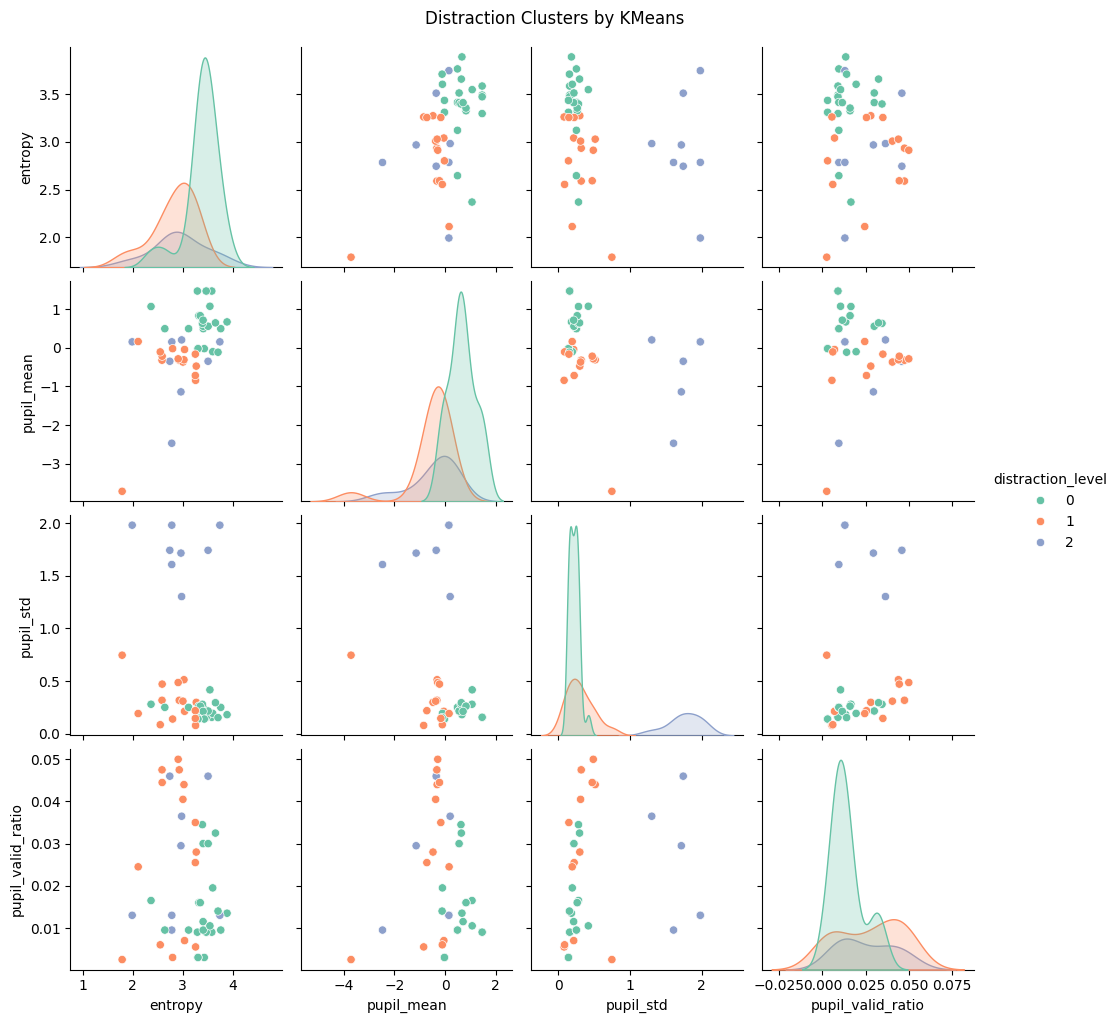

In [411]:
# visualize to check clusters

sns.pairplot(entropy_df.dropna(subset=FEATURES + ['distraction_level']),
             vars=FEATURES,
             hue='distraction_level',
             palette='Set2')
plt.suptitle("Distraction Clusters by KMeans", y=1.02)
plt.show()


Shows that pupil_valid_ratio isn't that useful. Would be much preferred to have blinks, but this wasn't included in the dataset

In [412]:
# check how many points in each cluster
distraction_cluster_counts = entropy_df['distraction_level'].value_counts().sort_index()
print("Distraction cluster counts:")
print(distraction_cluster_counts)


Distraction cluster counts:
distraction_level
0    23
1    15
2     8
Name: count, dtype: int64


### Train
#### Naive Bayes and Logistic Regression

In [413]:
# train, test, split first

# define X and y from train_df
X = train_df[features]
y = train_df[target]

# set aside 20% for final testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [414]:
# Naive Bayes Classification
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.67      0.80         3
           2       0.67      1.00      0.80         2

    accuracy                           0.90        10
   macro avg       0.89      0.89      0.87        10
weighted avg       0.93      0.90      0.90        10



In [415]:
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         3
           2       1.00      0.50      0.67         2

    accuracy                           0.90        10
   macro avg       0.92      0.83      0.84        10
weighted avg       0.93      0.90      0.89        10



LR performs slightly better

### Test (one participant)

In [416]:
# Naive Bayes model

# predict on test set
y_pred_nb = clf_nb.predict(X_test)

print("[TEST] Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

# confusion matrix, but joke is im the one who is confused
print("Confusion Matrix (Naive Bayes):")
print(confusion_matrix(y_test, y_pred_nb))

[TEST] Naive Bayes Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.67      0.80         3
           2       0.67      1.00      0.80         2

    accuracy                           0.90        10
   macro avg       0.89      0.89      0.87        10
weighted avg       0.93      0.90      0.90        10

Confusion Matrix (Naive Bayes):
[[5 0 0]
 [0 2 1]
 [0 0 2]]


In [417]:
# Logistic Regression model
# Predict on test set
y_pred_lr = clf_lr.predict(X_test)

print("[TEST] Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# confusion matrix
print("Confusion Matrix (LogReg):")
print(confusion_matrix(y_test, y_pred_lr))


[TEST] Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      1.00      0.86         3
           2       1.00      0.50      0.67         2

    accuracy                           0.90        10
   macro avg       0.92      0.83      0.84        10
weighted avg       0.93      0.90      0.89        10

Confusion Matrix (LogReg):
[[5 0 0]
 [0 3 0]
 [0 1 1]]


In [418]:
def process_all_participants(base_dir="gaipat_data/participants") -> pd.DataFrame:
    all_dfs = []

    participants = [p for p in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, p))]

    for pid in participants:
        try:
            data = load_participant_figure_data(base_dir, participant_id=pid)
            df_screen = data['df_screen']
            df_table = data['df_table']
            pupil_df = data['pupil_df']

            df_merged = merge_preprocess_gaze(df_screen, df_table)
            entropy_df = compute_entropy_over_time(df_merged)
            
            pupil_df = preprocess_pupil_data(pupil_df)
            entropy_df = compute_pupil_features(entropy_df, pupil_df)

            # Assign distraction levels based on participant's own entropy
            features = ['entropy', 'pupil_mean', 'pupil_std', 'pupil_valid_ratio']
            entropy_df = assign_distraction_levels_kmeans(entropy_df, features)

            # Add participant_id before cleanup
            entropy_df['participant_id'] = pid

            # Final cleanup
            print(f"[DEBUG] {pid} → Before dropna: {len(entropy_df)} rows")

            entropy_df = entropy_df.dropna(subset=features + ['distraction_level'])

            print(f"[DEBUG] {pid} → After dropna: {len(entropy_df)} rows")

            if not entropy_df.empty:
                all_dfs.append(entropy_df)

        except Exception as e:
            print(f"[SKIPPED] {pid}: {e}")

    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

full_df = process_all_participants()
print(full_df.shape)
full_df.head()

[INFO] Testing participant: 87891249
[INFO] Testing figure: sc
[SUCCESS] Loaded screen gaze: (4525, 3)
[SUCCESS] Loaded table gaze: (3432, 3)
[INFO] Loaded pupil data: (533, 6)
[INFO] Loaded screen events and states
[INFO] Loaded table events and states
[SKIPPED] 87891249: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
[INFO] Testing participant: 34055055
[INFO] Testing figure: sc
[SUCCESS] Loaded screen gaze: (928

,start_time,end_time,entropy,pupil_mean,pupil_std,pupil_valid_ratio,distraction_level,participant_id
0,1705048364527,1705048366527,2.699514,0.139647,1.175772,0.0190,1,34055055
1,1705048365027,1705048367027,3.277613,0.487322,1.295028,0.0185,0,34055055
2,1705048365527,1705048367527,3.363287,1.166028,0.586346,0.0190,0,34055055
3,1705048366027,1705048368027,3.013661,1.181922,0.518333,0.0185,0,34055055
4,1705048366527,1705048368527,2.824863,0.791070,1.113824,0.0180,0,34055055


In [419]:
# print columns of full_df to check if everything is there
print("[DEBUG] Full DataFrame Columns:") 
print(full_df.columns)

[DEBUG] Full DataFrame Columns:
Index(['start_time', 'end_time', 'entropy', 'pupil_mean', 'pupil_std',
       'pupil_valid_ratio', 'distraction_level', 'participant_id'],
      dtype='object')


In [420]:
# train classifiers helper function
def train_classifiers(train_df, test_df, features, target):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix

    X_train = train_df[features]
    y_train = train_df[target].astype(int)
    X_test = test_df[features]
    y_test = test_df[target].astype(int)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf_nb = GaussianNB()
    clf_nb.fit(X_train_scaled, y_train)

    clf_lr = LogisticRegression(max_iter=1000)
    clf_lr.fit(X_train_scaled, y_train)

    print("[Naive Bayes Results]")
    print(classification_report(y_test, clf_nb.predict(X_test_scaled)))
    print(confusion_matrix(y_test, clf_nb.predict(X_test_scaled)))

    print("\n[Logistic Regression Results]")
    print(classification_report(y_test, clf_lr.predict(X_test_scaled)))
    print(confusion_matrix(y_test, clf_lr.predict(X_test_scaled)))


In [421]:
# Train/test split, split by participant to prevent data leakage that was happening before
participant_ids = full_df['participant_id'].unique()
train_ids, test_ids = train_test_split(participant_ids, test_size=0.2, random_state=42)
train_df = full_df[full_df['participant_id'].isin(train_ids)].copy()
test_df = full_df[full_df['participant_id'].isin(test_ids)].copy()

train_classifiers(train_df, test_df, FEATURES, TARGET)

# Assign distraction levels using ONLY training data
thresholds = train_df['entropy'].quantile([1/3, 2/3]).values
train_df['distraction_level'] = pd.cut(
    train_df['entropy'],
    bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
    labels=[0, 1, 2]
).astype(int)

test_df['distraction_level'] = pd.cut(
    test_df['entropy'],
    bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
    labels=[0, 1, 2]
).astype(int)

print("[DEBUG] Any test participant in train set?",
      set(train_df['participant_id']) & set(test_df['participant_id']))

print("[DEBUG] Distraction levels in test set:", test_df['distraction_level'].value_counts())


[Naive Bayes Results]
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       221
           1       0.75      0.33      0.46       146
           2       0.38      0.22      0.28       135

    accuracy                           0.52       502
   macro avg       0.55      0.46      0.46       502
weighted avg       0.54      0.52      0.48       502

[[182   3  36]
 [ 86  48  12]
 [ 92  13  30]]

[Logistic Regression Results]
              precision    recall  f1-score   support

           0       0.48      0.73      0.58       221
           1       0.69      0.32      0.44       146
           2       0.30      0.22      0.26       135

    accuracy                           0.48       502
   macro avg       0.49      0.43      0.43       502
weighted avg       0.50      0.48      0.45       502

[[162   5  54]
 [ 84  47  15]
 [ 89  16  30]]
[DEBUG] Any test participant in train set? set()
[DEBUG] Distraction levels in test set: dist

In [422]:
print(full_df.groupby('distraction_level')['entropy'].describe())


                    count      mean       std       min       25%       50%  \
distraction_level                                                             
0                  1088.0  3.337021  0.571919  0.885067  3.014552  3.408755   
1                   753.0  3.116226  0.670629  0.918296  2.695170  3.184168   
2                   689.0  3.340501  0.565897  1.000000  3.000000  3.368042   

                        75%       max  
distraction_level                      
0                  3.736442  4.715312  
1                  3.623192  4.648956  
2                  3.736441  4.501398  


Some overfitting going on with LR, likely due to low number of participants, gonna try leave-one-out-cross-validation. Here's a reusable function: 

In [423]:
def run_lopocv(df, features, target):
    groups = df['participant_id']
    X = df[features]
    y = df[target].astype(int)

    nb_preds, nb_trues = [], []
    lr_preds, lr_trues = [], []

    logo = LeaveOneGroupOut()
    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Naive Bayes
        nb = GaussianNB()
        nb.fit(X_train_scaled, y_train)
        nb_preds.extend(nb.predict(X_test_scaled))
        nb_trues.extend(y_test)

        # Logistic Regression
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train_scaled, y_train)
        lr_preds.extend(lr.predict(X_test_scaled))
        lr_trues.extend(y_test)

    print("[LOPOCV Naive Bayes Results]")
    print(classification_report(nb_trues, nb_preds))
    print(confusion_matrix(nb_trues, nb_preds))

    print("\n[LOPOCV Logistic Regression Results]")
    print(classification_report(lr_trues, lr_preds))
    print(confusion_matrix(lr_trues, lr_preds))

run_lopocv(full_df, FEATURES, TARGET)

[LOPOCV Naive Bayes Results]
              precision    recall  f1-score   support

           0       0.44      0.75      0.56      1088
           1       0.42      0.27      0.33       753
           2       0.24      0.07      0.10       689

    accuracy                           0.42      2530
   macro avg       0.37      0.36      0.33      2530
weighted avg       0.38      0.42      0.37      2530

[[819 178  91]
 [494 203  56]
 [538 105  46]]

[LOPOCV Logistic Regression Results]
              precision    recall  f1-score   support

           0       0.43      0.72      0.54      1088
           1       0.40      0.30      0.34       753
           2       0.22      0.05      0.08       689

    accuracy                           0.41      2530
   macro avg       0.35      0.36      0.32      2530
weighted avg       0.36      0.41      0.36      2530

[[778 216  94]
 [497 225  31]
 [527 126  36]]


Note to self for later to improve model performance in future iterations with more data:
- add AOIs for both screen? 
- Add events.csv logic to: Track task steps, extract errors or redundant actions, add task_phase, action_count, or task_efficiency features